In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta
from IPython.display import Image

Before we dive into the project, I would like to first recommend a YouTube video by Cassie Kozyrkov (head of Decision Intelligence at Google) which explains Frequentist and Bayesian statistical perspectives clearly. The video link is: https://www.youtube.com/watch?v=GEFxFVESQXc

To sum it up:
- **Bayesian**: they are interested in their own opinion, from their own perspective of view. A Bayesian can never be wrong, because it's always their opinion. They take a start opinion, they see some evidence, they get a new opinion -- that's still their opinion. They have a sensible way of updating opinions with data. 
- **Frequentist**: they care very much about the true answer, which is fixed in the universe. And their analysis is oriented on that truth. They have a notion of 'getting it right'. They have the idea of "the method's quality", and they would like to do the experiments FREQUENTLY (hence the name) to get it right.
- **Statistics** is the discipline of changing one's mind under uncertainty. Those two above perspectives shows you two ways of changing your mind.
    - if you want to take ur personal opinion, add data to it, and see how your opinion should reasonably change -- go Bayesian
    - if you have an action by default, and you want to see if evidences are strong enough to convince you to continue taking or not to take the action (aka you care about the method's quality to make you stupidly leave the action, or continue the action even though you shouldn't) -- go Frequentist
    
Now let's work on the project!

### 1. Experiment Definition

We developed a new webpage and want to test its effects on purchase conversion. As such we split our users evenly into 2 groups:
1. **Control**: They get the old webpage
2. **Treatment**: They get the new webpage

*Assumption:*

SUVTA (Stable Unit Treatment Value Assumption): No interaction effects between units (users here) in control/ treatment. It's an assumption when conducting these experiments. 

Metric we want to track:
$$
\text{purchase conversion} = \frac{\text{# of Converted Users}}{\text{# of Exposed Users}}
$$

We have 3 weeks of logged exposure/conversion data. Let's define these terms:
1. **Exposure**: A user is bucketed as control or treatment and sees their corresponding page for the first time in the experiment duration
2. **Conversion**: An exposed user makes a purchase within 7 days of being first exposed

Questions you should ask when setting up a test:
- How do you think the experiment will fair?
- Do we have actionable next steps laid out?

### 2. Data Collection

Let's use some A/B testing data: https://www.kaggle.com/saraabdelaal/abtestdata

In [2]:
df = pd.read_csv('datasets/ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

Each row is logged when user is exposed to a webpage.
- **timestamp**: time the user is first exposed
- **group**: bucket
- **landing_page**: Which page are they seeing
- **converted**: Initialized to 0. Changes to 1 if the user makes a purchase within 7 days of first exposure

In [5]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


In [44]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [45]:
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

### 3. Data Processing

Check if there are missing values, or some repeated exposures for some users

In [6]:
# missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [22]:
# repeated exposures for users
user_info = df.groupby('user_id')['landing_page'].nunique()

In [23]:
user_info.head()

user_id
630000    1
630001    1
630002    1
630003    1
630004    1
Name: landing_page, dtype: int64

In [25]:
type(user_info)

pandas.core.series.Series

In [31]:
repeated_users = user_info[user_info != 1].index.tolist()

In [32]:
len(repeated_users)

1998

In [33]:
repeated_users[:3]

[630052, 630126, 630137]

In [41]:
sample = df[df['user_id'].isin(repeated_users)]

In [37]:
sample.head()

,user_id,timestamp,group,landing_page,converted
192,656468,2017-01-18 07:13:29.805052,treatment,new_page,1
226,773693,2017-01-23 18:05:45.167335,control,old_page,1
246,704650,2017-01-04 19:10:52.655062,treatment,new_page,0
276,784557,2017-01-04 10:39:41.450143,treatment,new_page,0
303,753749,2017-01-06 01:30:10.493842,control,old_page,0


In [39]:
sample[sample.user_id == 656468]

,user_id,timestamp,group,landing_page,converted
192,656468,2017-01-18 07:13:29.805052,treatment,new_page,1
110937,656468,2017-01-02 16:31:05.777407,treatment,old_page,0


Given that there are repeated exposures to some users, we need to deal with that.

Here we choose to get First timestamp for each username. In this dataset, it is the timestamp of first conversion, but in reality, make sure to do one of the following:
1. Get timestamp of first exposure
2. Remove users with multiple buckets

In [42]:
# Method I. Get timestamp of first exposure
first_conversion = sample.groupby('user_id')['timestamp'].min().to_frame().reset_index()
sample = sample.merge(first_conversion, on=['user_id', 'timestamp'])
sample.head()

,user_id,timestamp,group,landing_page,converted
0,784557,2017-01-04 10:39:41.450143,treatment,new_page,0
1,753749,2017-01-06 01:30:10.493842,control,old_page,0
2,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
3,793580,2017-01-08 03:25:33.723712,control,new_page,1
4,727266,2017-01-08 03:23:50.487865,treatment,new_page,0


In [43]:
sample.shape

(1998, 5)

In [46]:
# Method II: Remove users with multiple buckets 
# (since the size of repeated users are small compared to the total sample size)
counter = df['user_id'].value_counts()
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
user_data = df.merge(valid_users, on=['user_id'])

In [47]:
user_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
# two ways to count # of repeated user_ids
# method 1:
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

In [50]:
# method 2: 
res_user = df.groupby('user_id').count()
len(res_user[res_user.landing_page != 1])

3894

In [51]:
# now, continue dealing with data which removes repeated user exposures
# Add week column to see the data
user_data['week'] = user_data['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
user_data.sample()

,user_id,timestamp,group,landing_page,converted,week
151757,675904,2017-01-08 15:31:02.209424,treatment,new_page,0,1


In [52]:
user_data['week'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64

### 4. Experiment: Frequentist Approach

In [53]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = user_data[user_data['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


#### Chi-Squared Test

(for the categorical variable: converted or not)

$$
H_0: \text{Control & Treatment are independent} \\
H_A: \text{Control & Treatment are not independent} 
$$

In [54]:
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [55]:
contingency_table

array([[ 17220, 126073],
       [ 17025, 126372]], dtype=int64)

In [56]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [57]:
chi, p_value

(1.426794609399621, 0.23228827305833816)

Since the p_value > 0.05, we cannot reject null hypothesis. Hence, we cannot conclude if there exists a relationship between the control and treatment groups.

In [58]:
print(f"{round(p_value * 100, 2)}% probability that a more extreme chi square than {round(chi, 3)} would have occured by chance")

23.23% probability that a more extreme chi square than 1.427 would have occured by chance


If you would to say something about the actual maginitude of lift, like something below, you should go with Bayesian.

In [59]:
print(f"(We CANNOT say this) We are {round(p_value * 100, 2)}% confident that our lift = {lift}%")

(We CANNOT say this) We are 23.23% confident that our lift = -0.144%


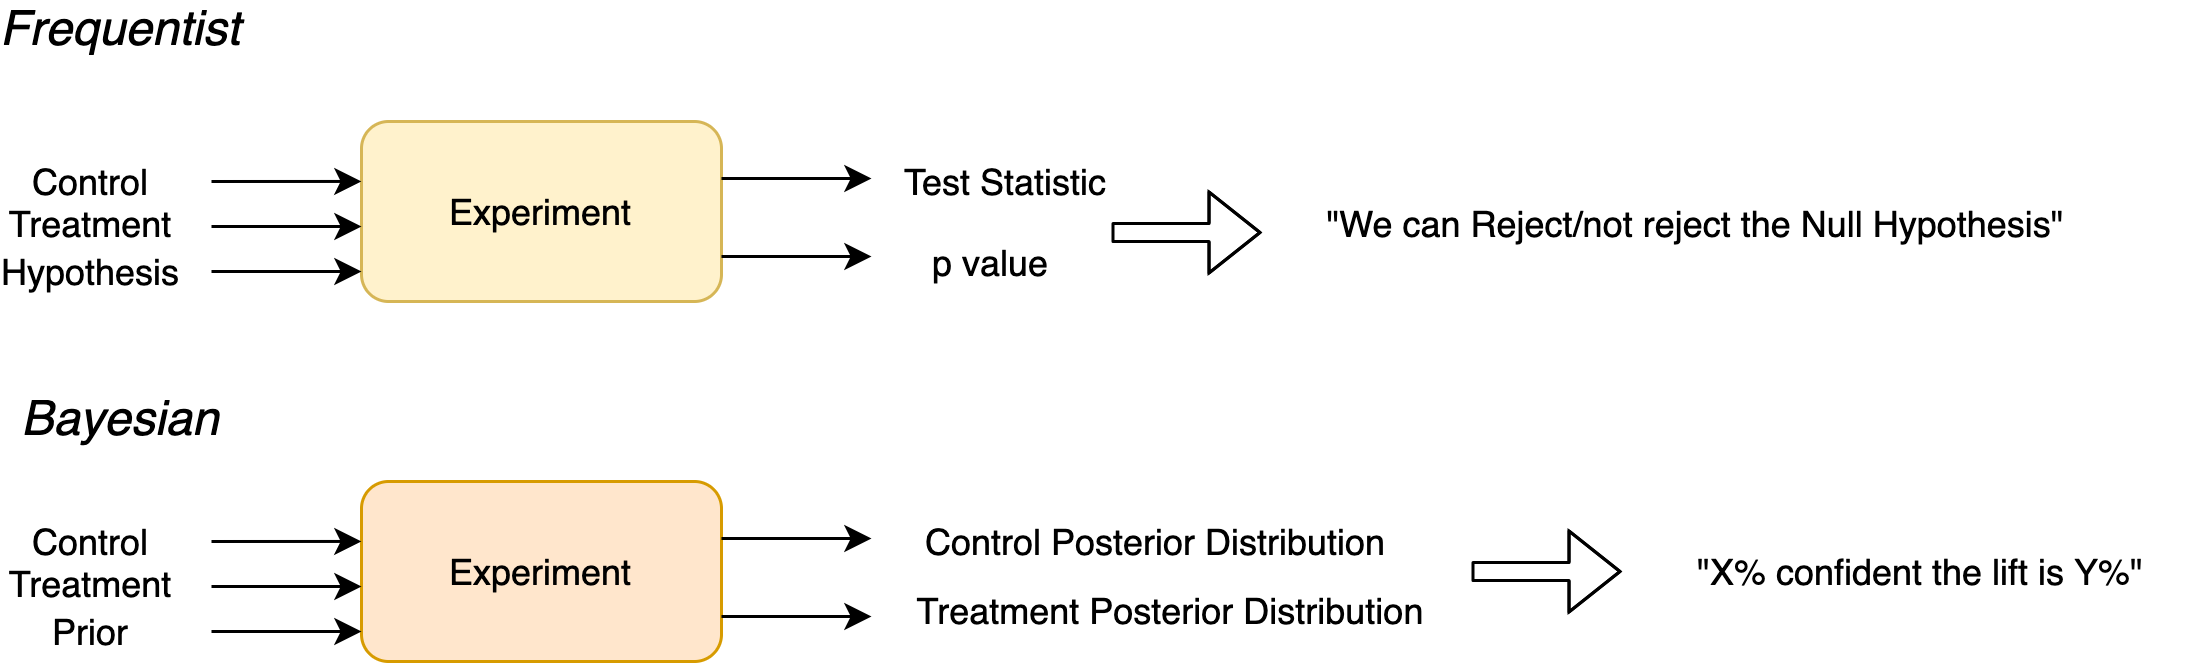

In [60]:
Image(filename='datasets/b_v_f.png') 
# Frequentist outputs scalars, while Bayesian outputs distributions. 

### 5. Experiment: Bayesian Approach

We want to input the _prior distribution_ and have the experiment update the parameters to create _posterier distributions_. Since these prior & posterior distributions will be used to sample Conversion Rate, we model them after beta distribtion.

Let's create the prior beta distribtion from the first weeks of conversion data

In [62]:
prior = user_data[(user_data['week'] == 1) & (user_data['group']=='control')]

In [63]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

In [64]:
prior_means[:10]

[0.117, 0.129, 0.13, 0.125, 0.109, 0.144, 0.109, 0.128, 0.128, 0.129]

In [65]:
# Model Beta Distribtion from sample means
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)

In [76]:
# Get Stats
NUM_WEEKS = 2 # Vary number to get experiment data at weekly points in time
experiment_data = user_data[(user_data['week'] > 1) & (user_data['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.817%
Control Conversion Rate: 11.925%
Lift = -0.009%


In [77]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")
print('We are {:.2f}% confident that the treatment group would be larger than control group by {}%'.format(probability * 100, lift))

Probability that treatment > control: 33.900000000000006%
We are 33.90% confident that the treatment group would be larger than control group by -0.009%


In [78]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.11924689096116665, Variance: 2.248705041557851e-06
Treatment Posterior: Mean: 0.1181938477691885, Variance: 2.2310343861881793e-06


In [79]:
# now let's run the experiment with one more week
NUM_WEEKS = 3 # Vary number to get experiment data at weekly points in time
experiment_data = user_data[(user_data['week'] > 1) & (user_data['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.893%
Control Conversion Rate: 12.025%
Lift = -0.011%


In [80]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")
print('We are {:.2f}% confident that the treatment group would be larger than control group by {}%'.format(probability * 100, lift))

Probability that treatment > control: 18.6%
We are 18.60% confident that the treatment group would be larger than control group by -0.011%


In [81]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12024138917285032, Variance: 1.146783322632739e-06
Treatment Posterior: Mean: 0.11893168290630549, Variance: 1.1361040019612609e-06


In [82]:
# now let's run the experiment with one more week
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = user_data[(user_data['week'] > 1) & (user_data['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.909%
Control Conversion Rate: 12.058%
Lift = -0.012%


In [83]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")
print('We are {:.2f}% confident that the treatment group would be larger than control group by {}%'.format(probability * 100, lift))

Probability that treatment > control: 17.4%
We are 17.40% confident that the treatment group would be larger than control group by -0.012%


In [84]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12056137135488972, Variance: 1.0335705008512748e-06
Treatment Posterior: Mean: 0.11909246777203639, Variance: 1.0244705641747872e-06


We can even make statements like the following which are actionable:

In [85]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we are seeing a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")

Probability that we are seeing a 2% lift: 0.3%


Advantages of Frequentist over Bayesian:
- No prior knowledge of the data needed
- Computationally easy to do
- Standard procedure across many places, including most medical and research practices
- Easy to interpret

Advantages of Bayesian over Frequentist:
- Results are more interpretable than the ones we got from the frequentist approach
- We can interpret results at any point during the experiment. Don't need to wait for an arbitrary "statsig"

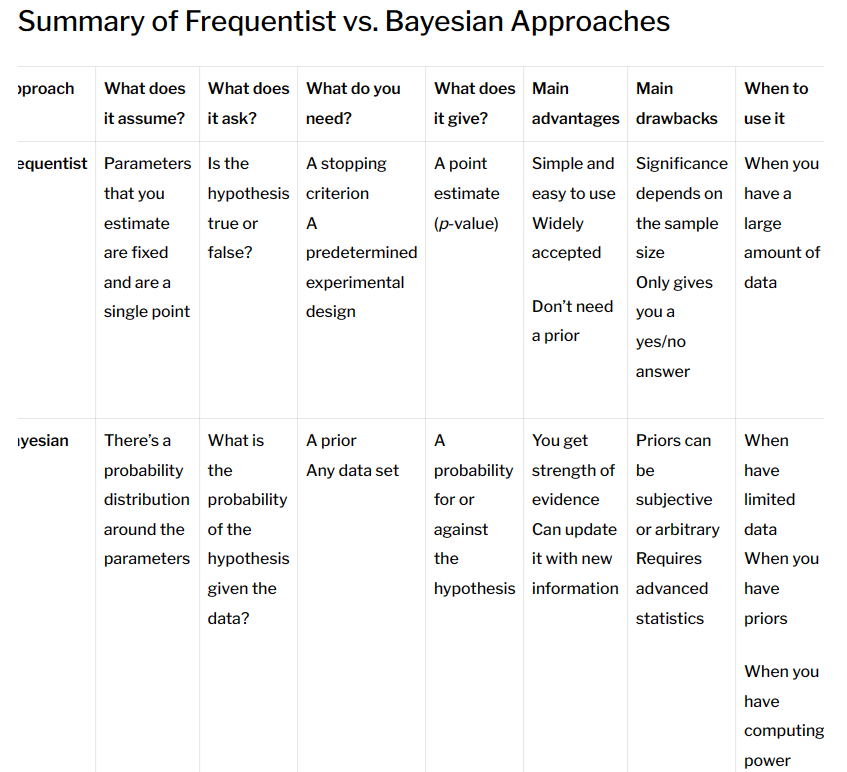

In [87]:
Image(filename='datasets/Frequentist_vs_Bayesian.png') 
# first row: Frequentist; second row: Bayesian

# Reference: Edanz Group. (2022). Frequentist vs. Bayesian Statistics – Which should you use? Edanz Learning Lab. https://learning.edanz.com/frequentist-bayesian-statistics/

More notes from Cassie on the topic

### Frequentist versus Bayesian
#### Which words tell you who you’re dealing with?
What jargon tells you that you’ve stepped into their territory?
**Frequentist**: confidence interval, p-value, power, significance
**Bayesian**: credible interval, prior, posterior

#### What are their goals?
What are they using statistics to change their minds about?
**Frequentist**: actions to take (default action)
**Bayesian**: opinions to have (prior belief)

#### What is the main difference?
**Frequentist**: the parameter is a fixed quantity (no probability about it)
**Bayesian**: the parameter is a random variable (no right answer)

#### What’s in it for you?
What do you gain by joining their way of thinking?
**Frequentist**: it makes sense to talk about your method’s quality and “getting the answer right”
**Bayesian**: intuitive definitions, e.g. credible intervals are what you wish confidence intervals were (but aren’t!)

#### What do you give up?
What do you lose if you choose their side?
**Frequentist**: the core concepts are harder to wrap your head around (e.g. p-values and confidence intervals have counter-intuitive, wordy definitions) and lazy thinkers make a hash out of them frequent-ly.
**Bayesian**: you lose the ability to talk about any notion of “right answers” and “method quality” — there’s no such thing as statistically significant or rejecting the null. There’s only “more likely” and “less likely” …from your perspective.

#### So, which one is better?
Wrong question! The right one to choose depends on how you want to approach your decision-making. For example, if you have no default action, go Bayesian. Without a default action, the Frequentist approach is less practical than the Bayesian approach unless you have special philosophical reasons for invoking the concept of TRUTH in your calculations.

(Note: those last three words are important. We’re not talking about the concept of truth in general, but rather about how it’s handled in the math that powers these approaches to statistics. The distinction between the two camps boils down to whether you treat the parameter of interest as a fixed constant or not.)

#### Okay… so which one is more objective?
Neither! They’re both based on assumptions, so they’re fundamentally subjective. 

The key difference is how they assist decision-making once the decision context has been framed.

#### Wait, what about sample size? Isn’t Bayesian the way to go with small data?
If you’ve been hanging out with the “Frequentist if there’s lots of data, Bayesian if there isn’t” folks, you might be sold on the idea that you should let sample size decide which camp to go with. Alas, the reasoning behind their advice gets wobbly if you poke it.

Yes, it’s true that Frequentists spurn babby datasets. If you’ve got more fingers than examples, they’ll almost surely tell you not to bother. 

Yes, it’s true that if you take a Bayesian approach, you can proceed with as little as one (!) datapoint. The math checks out. Sure. You can do it.

…But *should* you?

Being allowed to proceed with a pittance of data might be a bug instead of a feature. There are circumstances where you definitely don’t want to be doing that. (Statistics isn’t alchemy. We’re not making gold out of thin air. There’s the same amount of data in one datapoint no matter which school of thought you pledge fealty to.)

The way to “require less data” is to make bigger assumptions (this holds for both philosophies)… so do take a moment to ponder the nutritional content of your conclusions when your main ingredient isn’t data but, essentially, some nonsense you made up. If you take yourself too seriously when working with tiny data, expert Bayesians and Frequentists alike will forget their differences long enough to join in a belly laugh at your expense.

#### Cassie, you’re killing us here. Are you Bayesian or Frequentist?
Both! I choose based on how I’m framing my decision-making. It depends on whether the situation calls for choosing between actions or forming an evidence-based opinion.

#### Should I pick a side?
I’d advise against committing to just one camp (unless you’ve spent a few years thinking about the philosophy of statistics and you’re willing to die on this hill).

Honestly, it’s a little silly to declare yourself as one or the other unless you’ve pondered them very deeply. Having had the pleasure of doing my graduate work at Duke University (which is to Bayesian statistics approximately what the Vatican is to Catholicism), I noticed that the loudest loudmouths about the superiority of Bayesian statistics aren’t the professors… it’s the newbie students who are relieved not to have to memorize the definition of the weird Frequentist confidence interval anymore (the Bayesian credible interval is so much easier). The profs understand that “better” depends on why you’re trying to do. They spend a lot of time thinking in the Bayesian way because it fits the kind of decision approaches they’re interested in. So, my advice? Don’t pick a side. See them as two different approaches that fit two different styles of decision-making and reasoning, then leave yourself the option of using whichever one suits the mindset/context you find yourself in.

Reference: Kozyrkov, C. (2023, April 30). Statistics: Are you Bayesian or Frequentist? - Towards Data Science. Medium. https://towardsdatascience.com/statistics-are-you-bayesian-or-frequentist-4943f953f21b